# Hugging Face Course Part 1: Project

## Introduction
After completing the first part of the Hugging Face course, students are encouraged to fine-tune a pretrained model on a text classification problem. In this notebook, I am undertaking this task. As this is my first project with Hugging Face, I will primarily follow the concepts taught in the course. Specifically, I will use the `awesome-japanese-nlp-classification-dataset`, which identifies whether a GitHub repository description pertains to Japanese natural language processing, categorizing labels as relevant `(1)` or not relevant `(0)`, to fine-tune a bert-based model.

The `taishi-i/awesome-japanese-nlp-classification-model` serves as the baseline model for the `awesome-japanese-nlp-classification-dataset`. This model was trained on the dataset, saved using the development data, and evaluated using the test data. My objective is to build upon this baseline, leveraging the knowledge gained from the Hugging Face course to fine-tune and potentially improve the model's performance on the given classification task.

## Table of Contents
---
- [Introduction](#Introduction)
- [Selecting the Dataset and Model](#Selecting-the-Dataset-and-Model)
  - [Dataset Selection](#Dataset-Selection)
  - [Model Selection](#Model-Selection)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  - [Load the data](#Load-the-data)
  - [Explore the data](#Explore-the-data)
- [Preprocessing the Data](#Preprocessing-the-Data)
  - [Splitting the Dataset](#Splitting-the-Dataset)
  - [Tokenizing the Dataset](#Tokenizing-the-Dataset)
- [Discussion and Recommendations](#Discussion-and-Recommendations)

# Selecting the Dataset and Model
I would like to fine-tune a model for a text classification problem, as this is what was shown in the first part of the course. As I took two years of Japanese language courses in college, I will choose a dataset dealing with the Japanese language.

### Dataset Selection
I went to the [Huggging Face website](https://huggingface.co/). On Datasets I filtered by:

1.   Tasks Categories: `text-classification`
2.   Languages: `Japanese`

I then selected the `taishi-i/awesome-japanese-nlp-classification-dataset`. Below is the dataset summary from the HuggingFace Hub.

**Dataset Summary (from the Dataset card):**
This dataset identifies whether a GitHub repository description pertains to Japanese natural language processing (NLP). The labels are categorized as "Relevant (1)" and "Not Relevant (0)".

Problem Setting:

- Training Data: Repository descriptions from before 2022
- Test Data: Repository descriptions from 2023
- Objective: To detect repositories related to Japanese NLP

Data Collection:

- Positive Examples: Repositories listed in "awesome-japanese-nlp-resources" as of September 9, 2023
- Negative Examples: Collected from the GitHub API and visually confirmed
- Note: The annotation process is subjective

Dataset Features:

- Subjective labeling
- Mixed English and Japanese descriptions
- Imbalanced label distribution


### Model Selection
I then went to the tab "Models" and selected:

1.   Tasks: `Text Classification`
2.   Model:
`taishi-i/awesome-japanese-nlp-classification-model`

This is the default model to test with my particular chocie of dataset. I will later analyze transfer learning through using this as a pretrained model.

**Model summary (taken from the Model card):**
This model is the baseline model for `awesome-japanese-nlp-classification-dataset`. It was trained on this dataset, saved using the development data, and evaluated using the test data. The following table shows the evaluation results.

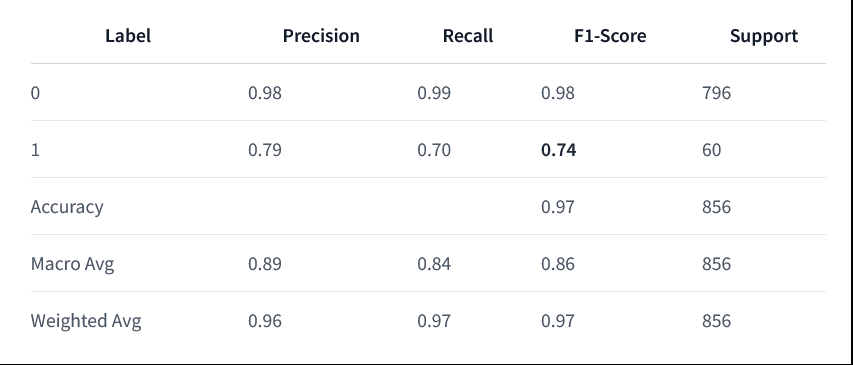

With the model and dataset selected I can now install the Transformers and Datasets libraries to begin my analysis.

In [1]:
%%capture
!pip install datasets transformers[sentencepiece]

# Exploratory Data Analysis
I will start with the first part of [chapter 3](https://huggingface.co/course/chapter3/2?fw=tf) in the HF 🤗 course. I first load the data and then do some basic exploratory data analysis.

### Load the data


I include all relevant libraries for downsteam processing.

In [15]:
from datasets import load_dataset
import pprint
import operator
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

I then use the Datasets library to download and cache the Japanse NLP classification dataset.

In [2]:
raw_dataset = load_dataset("taishi-i/awesome-japanese-nlp-classification-dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5496 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/856 [00:00<?, ? examples/s]

### Explore the data
I then perform a brief exploratory data analysis to understand the dataset before preparing it for fine-tuning.

In [3]:
# See the raw_data
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'url', 'created_at'],
        num_rows: 5496
    })
    validation: Dataset({
        features: ['label', 'text', 'url', 'created_at'],
        num_rows: 400
    })
    test: Dataset({
        features: ['label', 'text', 'url', 'created_at'],
        num_rows: 856
    })
})

As shown above, this dataset contains the columns: `label`, `text`, `url`, and `created_at`. There are 6,752 Github repository descriptions in total. Let's see one of the items as an example:

In [13]:
# Number of example to print
num_sample = 44 # change it to see other samples
pprint.pprint(raw_dataset["train"][num_sample])

{'created_at': '2009-11-04T22:19:17Z',
 'label': 0,
 'text': 'Acceptance test framework for web applications',
 'url': 'https://github.com/teamcapybara/capybara'}


I also inspect the characteristics of the features and check the data type of the columns.

In [14]:
# Explore the features
raw_dataset["train"].features

{'label': ClassLabel(names=['0', '1'], id=None),
 'text': Value(dtype='string', id=None),
 'url': Value(dtype='string', id=None),
 'created_at': Value(dtype='string', id=None)}

Now, I want to understand the balance of the classes: How many Github repos contain Japanese language for NLP and how many do not?

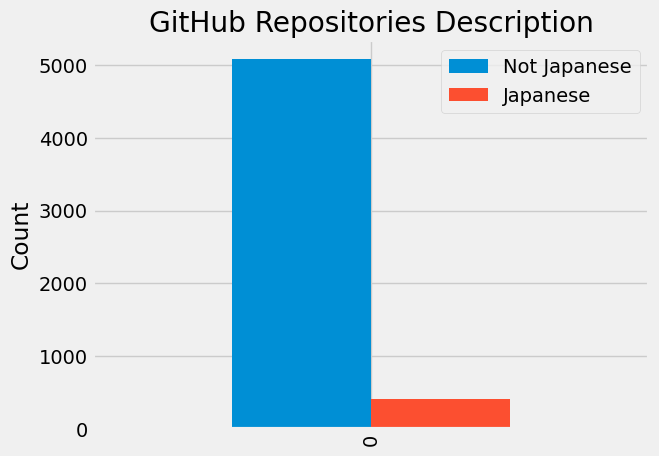

In [23]:
# Create a DataFrame from the raw dataset
github_df = pd.DataFrame()

# Count the occurrences of each label and map them to "Not Japanese" and "Japanese"
label_counts = pd.Series(raw_dataset["train"]["label"]).value_counts()
labels = ["Not Japanese", "Japanese"]

# Assign the counts to the DataFrame
for i, label in enumerate(labels):
    github_df.loc[0, label] = label_counts.get(i, 0)

# Plot the bar chart
ax = github_df.plot.bar()
ax.set_ylabel("Count")
ax.set_title("GitHub Repositories Description")
plt.show()

Clearly, most of the Github repositories don't contain Japanese language in their description (which makes sense). Let's continue analyzing.

Next, I will create a Dataframe of the dataset to take some statistics, such as:

*   General statistics about the features
*   The maximum, minimum and average number of characters that can be found in a `text`
*   The maximum, minimum and average number of characters that can be found in a `url`

This information could be useful when deciding how to training the model.



In [24]:
# Create the dataframe
df = pd.DataFrame(data=raw_dataset["train"], columns=raw_dataset["train"].features.keys())
df.head()

,label,text,url,created_at
0,0,HTML Abstraction Markup Language - A Markup Haiku,https://github.com/haml/haml,2008-02-11T22:55:26Z
1,0,Ruby on Rails,https://github.com/rails/rails,2008-04-11T02:19:47Z
2,0,Git Source Code Mirror - This is a publish-onl...,https://github.com/git/git,2008-07-23T14:21:26Z
3,0,Repository for collecting Locale data for Ruby...,https://github.com/svenfuchs/rails-i18n,2008-07-31T13:07:53Z
4,0,"Classier solution for file uploads for Rails, ...",https://github.com/carrierwaveuploader/carrier...,2008-08-28T18:39:49Z


In [28]:
# Generate descriptive statistics for the selected columns, including non-numeric ones
selected_columns = df[['label', 'text', 'url', 'created_at']]
description = selected_columns.describe(include='all')

# Display the description
description

,label,text,url,created_at
count,5496.000000,5496,5496,5496
unique,NaN,5496,5496,5496
top,NaN,"In stable diffusion, generate a sequence of im...",https://github.com/yownas/shift-attention,2022-09-30T19:45:09Z
freq,NaN,1,1,1
mean,0.074054,NaN,NaN,NaN
std,0.261882,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,0.000000,NaN,NaN,NaN
50%,0.000000,NaN,NaN,NaN
75%,0.000000,NaN,NaN,NaN


Next, I will analyze the text fields to visualize text length.

         Description                 Value
0       Longest text  ID: 3599, Chars: 609
1      Shortest text    ID: 3204, Chars: 2
2   Mean text length             58.054221
3  Empty text fields                     0


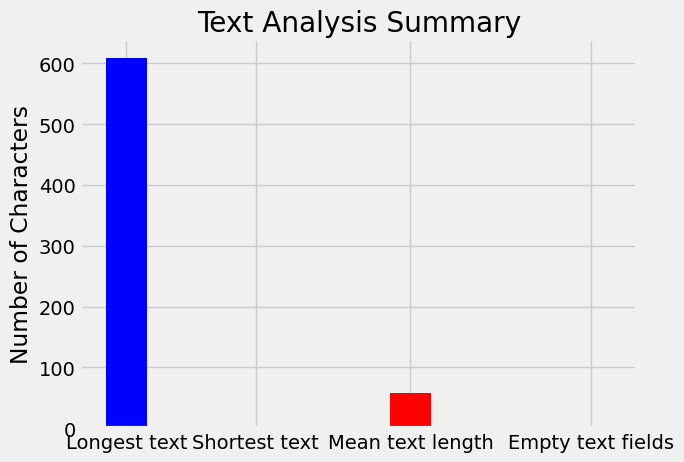

In [65]:
# Longest, shortest, and mean text lengths
lengths = df["text"].str.len()
longest_text_id, longest_text_num_char = lengths.idxmax(), lengths.max()
shortest_text_id, shortest_text_num_char = lengths.idxmin(), lengths.min()
mean_text_chars = lengths.mean()

# Find if there are empty text fields
num_empty_texts = (lengths == 0).sum()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Description': ['Longest text', 'Shortest text', 'Mean text length', 'Empty text fields'],
    'Value': [f"ID: {longest_text_id}, Chars: {longest_text_num_char}",
              f"ID: {shortest_text_id}, Chars: {shortest_text_num_char}",
              mean_text_chars,
              num_empty_texts]
})

# Display the summary table
print(summary_df)

# Create a bar chart for visualization
fig, ax = plt.subplots()

# Data for the bar chart
labels = ['Longest text', 'Shortest text', 'Mean text length', 'Empty text fields']
values = [longest_text_num_char, shortest_text_num_char, mean_text_chars, num_empty_texts]

# Bar positions
bar_positions = [0, 2.5, 5.5, 9]
ax.bar(bar_positions, values, color=['blue', 'green', 'red', 'purple'])

# Adding title and labels
ax.set_title('Text Analysis Summary')
ax.set_ylabel('Number of Characters')
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels)

# Show the plot
plt.show()

Similarly, I will make a plot to visualize the url length.

        Description                 Value
0       Longest URL  ID: 2317, Chars: 152
1      Shortest URL    ID: 109, Chars: 23
2   Mean URL length             40.863901
3  Empty URL fields                     0


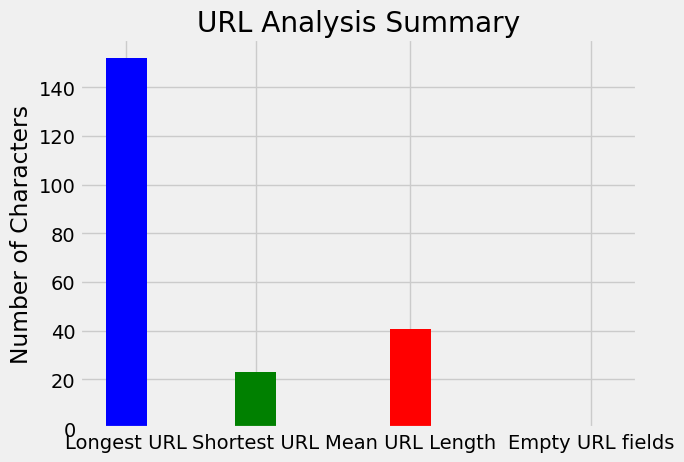

In [69]:
# Longest, shortest, and mean URL lengths
url_lengths = df["url"].str.len()
longest_url_id, longest_url_num_char = url_lengths.idxmax(), url_lengths.max()
shortest_url_id, shortest_url_num_char = url_lengths.idxmin(), url_lengths.min()
mean_url_chars = url_lengths.mean()

# Find if there are empty URL fields
num_empty_urls = (url_lengths == 0).sum()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Description': ['Longest URL', 'Shortest URL', 'Mean URL length', 'Empty URL fields'],
    'Value': [f"ID: {longest_url_id}, Chars: {longest_url_num_char}",
              f"ID: {shortest_url_id}, Chars: {shortest_url_num_char}",
              mean_url_chars,
              num_empty_urls]
})

# Display the summary table
print(summary_df)

# Create a bar chart for visualization
fig, ax = plt.subplots()

# Data for the bar chart
labels = ['Longest URL', 'Shortest URL', 'Mean URL Length', 'Empty URL fields']
values = [longest_url_num_char, shortest_url_num_char, mean_url_chars, num_empty_urls]

# Bar positions
bar_positions = [0, 2.5, 5.5, 9]
ax.bar(bar_positions, values, color=['blue', 'green', 'red', 'purple'])

# Adding title and labels
ax.set_title('URL Analysis Summary')
ax.set_ylabel('Number of Characters')
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels)

# Show the plot
plt.show()

### Exploratory Data Analysis summary
We can see that the majority of Github repositories analyzed do not have Japanese text in their description. From the Text/URL analysis, we can see that there is a fair amount of variance in the `text` and `url` columns of the Github dataframe. We won't perform any further anlaysis against null records and will jump into processing the data.


# Preprocessing the Data
We will now cover material from chapter 3 of the HF 🤗 course. I will split the dataset into a test and validation dataset and then tokenize and pad the the samples.

### Splitting the Dataset
This dataset only contains a training split. For this reason, I will preprocess of the data through creating two datasets out of the training split: one for training (75%) and one for validation (the remaining 25%).

In [15]:
# Create a train and validation split of the dataset
raw_datasets = load_dataset("taishi-i/awesome-japanese-nlp-classification-dataset", split="train")
raw_datasets = raw_datasets.train_test_split(test_size=0.25)

In [16]:
# Check the split
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'url', 'created_at'],
        num_rows: 4122
    })
    test: Dataset({
        features: ['label', 'text', 'url', 'created_at'],
        num_rows: 1374
    })
})

### Tokenizing the Dataset
As saw in course, we need to convert the text to number so we can use it in our model. This can be done using the tokenizer provided by the 🤗 Autotokenizer. It is important that we use the checkpoint based on the selected model.

In [17]:
# Tokenizer based on model's checkpoint
from transformers import AutoTokenizer

checkpoint = "google-bert/bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

The following function will allow us to tokenize our Dataset with using map() so we can keep the data as dataset. As explain in the last sections, I will only use the `text` field. I am also using the truncate option so sentences are no longer that the length supported by the model

In [23]:
# Tokenize function to use with Dataset.map()
def tokenize_funtion(example):
  return tokenizer(example["text"], truncation=True, padding=True)

In [24]:
# Create tokenize datasets
# batched=True so function is applied to multiple elements of dataset at once
tokenize_datasets = raw_datasets.map(tokenize_funtion, batched=True)
tokenize_datasets

Map:   0%|          | 0/4122 [00:00<?, ? examples/s]

Map:   0%|          | 0/1374 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'url', 'created_at', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4122
    })
    test: Dataset({
        features: ['label', 'text', 'url', 'created_at', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1374
    })
})

In [20]:
tokenize_datasets["train"][0]

{'label': 0,
 'text': '🗜 JavaScript parser, mangler and compressor toolkit for ES6+',
 'url': 'https://github.com/terser/terser',
 'created_at': '2015-01-11T16:06:46Z',
 'input_ids': [101,
  100,
  80017,
  50918,
  10165,
  117,
  23912,
  10815,
  10111,
  10212,
  77202,
  10129,
  53276,
  35481,
  10142,
  49004,
  11211,
  116,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

As you can see, we have now the fields needed for our model:
- `label`
- `inputs_id`: Note the special ids 101, 102
- `token_type_ids`: As explained in the course "this is what tells the model which part of the input is the first sentence and which is the second sentence"

## 3.3 Dynamic padding
We will now add dynamically padding to our sentences based on the batch and create our TensorFlow datasets (refer to Dynamic padding in [this part of the course](https://huggingface.co/course/chapter3/2?fw=tf))

In [21]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [25]:
# Create the TensorFlow datasets for training and validation
tf_train_dataset = tokenize_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["input_ids"],  # Use tokenized input_ids as labels
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8
)

tf_validation_dataset = tokenize_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["input_ids"],  # Use tokenized input_ids as labels
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


And this concludes this part of preprocessing the data. We are now ready to start fine-tunning our model!

#Part 4: Fine-tuning the model
This section corresponds to the section: [Fine-tuning a model with Keras](https://huggingface.co/course/chapter3/3?fw=tf) of the third of the third part of the 🤗 course. After the data preprocessing, we are ready to start training our model. In this part, we will cover the following items:
- Baseline model
- Fine-tune the model and compare with baseline model



## 4.1 Baseline model
Before fine-tuning the model, let's see how it performce as it is, so we can then compare it after the work put into this task. This is because the model is already fine-tuned for sentiment analysis on product reviews, which is very similar of sentiment analysis on movie reviews.

In [26]:
# Load the model from checkpoint
from transformers import TFAutoModelForSequenceClassification

checkpoint = "taishi-i/awesome-japanese-nlp-classification-model"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/987 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [27]:
preds_baseline_model = model.predict(tf_validation_dataset)

172/172 [==============================] - 34s 72ms/step


In [28]:
# Explore the predictions
preds_baseline_model

TFSequenceClassifierOutput(loss=None, logits=array([[ 2.8291957, -3.9435227],
       [ 2.3072803, -2.5267384],
       [ 2.8841844, -3.7744203],
       ...,
       [ 2.7799585, -3.901129 ],
       [ 2.8003979, -3.6430018],
       [ 2.8147788, -3.996321 ]], dtype=float32), hidden_states=None, attentions=None)

In [29]:
# Take the logits of the predictions
preds_baseline_model_logits = preds_baseline_model["logits"]
preds_baseline_model_logits

array([[ 2.8291957, -3.9435227],
       [ 2.3072803, -2.5267384],
       [ 2.8841844, -3.7744203],
       ...,
       [ 2.7799585, -3.901129 ],
       [ 2.8003979, -3.6430018],
       [ 2.8147788, -3.996321 ]], dtype=float32)

In [30]:
# We need numpy
import numpy as np

# Convert logits into the model’s class predictions to find the highest logit
class_preds = np.argmax(preds_baseline_model_logits, axis=1)
print(preds_baseline_model_logits.shape, class_preds.shape)

(1374, 2) (1374,)


In [33]:
from datasets import load_metric

metric = load_metric("glue", "cola")
metric.compute(predictions=class_preds, references=raw_datasets["test"]["label"])

{'matthews_correlation': 0.9684479578312353}

In [37]:
load_accuracy = load_metric("accuracy")

accuracy = load_accuracy.compute(predictions=class_preds, references=raw_datasets["test"]["label"])["accuracy"]
print(f"Accuracy: {accuracy}")

Accuracy: 0.9956331877729258


Using the model as it is we get an `accuracy` of 0.9956 (could be a different value depending on the split) and a [`matthews_correlation`](https://en.wikipedia.org/wiki/Phi_coefficient#Multiclass_case) of 0.96844 (also could be a different value). Let's see if we can improve these metrics by fine-tuning our model with the `muchocine` dataset.

## 4.2 Fine-tuning the model and comparing it with baseline model

We can now continue with our task and implement the part: [Fine-tuning a model with Keras](https://huggingface.co/course/chapter3/3?fw=tf) of the 🤗 course.
Let's start by creating a learning rate scheduler to adapt our learning rate as explained in the course:

In [53]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, BertTokenizer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from datasets import load_dataset

# Set up parameters
batch_size = 8
num_epochs = 10
checkpoint = "bert-base-multilingual-cased"

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(checkpoint)

# Load and preprocess the dataset
dataset = load_dataset("glue", "mrpc")

def tokenize_function(examples):
    return tokenizer(examples['sentence1'], examples['sentence2'], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tf_train_dataset = tokenized_datasets['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'token_type_ids'],
    label_cols=['label'],
    shuffle=True,
    batch_size=batch_size
)

tf_validation_dataset = tokenized_datasets['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'token_type_ids'],
    label_cols=['label'],
    shuffle=False,
    batch_size=batch_size
)

# Calculate the number of training steps
num_train_steps = len(tf_train_dataset) * num_epochs

# Set up the learning rate scheduler
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

# Set up the optimizer with the learning rate scheduler
opt = Adam(learning_rate=lr_scheduler)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


We can now compile our model using our optimizer with the implemented learning rate decay

In [54]:
# Load the model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

# Define the loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model with the custom optimizer, specifying Adam as a string
model.compile(optimizer='Adam', loss=loss, metrics=["accuracy"])

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can fit now our model

In [55]:
# Train the model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs
)

Epoch 1/10
459/459 [==============================] - 240s 298ms/step - loss: 0.6926 - accuracy: 0.6287 - val_loss: 0.6442 - val_accuracy: 0.6838
Epoch 2/10
459/459 [==============================] - 120s 261ms/step - loss: 0.6815 - accuracy: 0.6235 - val_loss: 0.7342 - val_accuracy: 0.6838
Epoch 3/10
459/459 [==============================] - 119s 260ms/step - loss: 0.6862 - accuracy: 0.6260 - val_loss: 0.6249 - val_accuracy: 0.6838
Epoch 4/10
459/459 [==============================] - 120s 262ms/step - loss: 0.6682 - accuracy: 0.6412 - val_loss: 0.6267 - val_accuracy: 0.6838
Epoch 5/10
459/459 [==============================] - 120s 261ms/step - loss: 0.6653 - accuracy: 0.6464 - val_loss: 0.6529 - val_accuracy: 0.6838
Epoch 6/10
459/459 [==============================] - 121s 263ms/step - loss: 0.6626 - accuracy: 0.6401 - val_loss: 0.6579 - val_accuracy: 0.6838
Epoch 7/10
459/459 [==============================] - 121s 263ms/step - loss: 0.6561 - accuracy: 0.6497 - val_loss: 0.6355 -

It seems that the model starts overfitting very quickly (look how the val_loss is increasing). I think that one of the reasons is that the model is very complex, and the dataset does not have many samples. Still, we see and improvement of the accuracy. We can play with the learning rate and the batch size among other features to try to avoid overfitting. This is out of the scope of this notebook. So, since I notices the model starts overfitting very soon, I will train it for less epochs.

In [56]:
# Implement linearly learning rate decay
from tensorflow.keras.optimizers.schedules import PolynomialDecay

batch_size = 8
num_epochs = 3

# From the course: https://huggingface.co/course/chapter3/3?fw=tf
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.

num_train_steps = len(tf_train_dataset) * num_epochs

# From the course: https://huggingface.co/course/chapter3/3?fw=tf
# From long experience, though, we know that transformer models benefit from a
# much lower learning rate than the default for Adam, which is 1e-3, also
# written as 10 to the power of -3, or 0.001. 5e-5 (0.00005), which is some
# twenty times lower, is a much better starting point
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [58]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
# Output the values right before the softmax is applied: the logits
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='Adam', loss=loss, metrics=["accuracy"])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
# Fit model in just 3 epochs
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs
)

Epoch 1/3
459/459 [==============================] - 199s 293ms/step - loss: 0.6935 - accuracy: 0.6268 - val_loss: 0.7674 - val_accuracy: 0.3162
Epoch 2/3
459/459 [==============================] - 124s 270ms/step - loss: 0.6908 - accuracy: 0.6208 - val_loss: 0.6310 - val_accuracy: 0.6838
Epoch 3/3
459/459 [==============================] - 120s 262ms/step - loss: 0.6840 - accuracy: 0.6420 - val_loss: 0.6572 - val_accuracy: 0.6838


Here we can see that the val_accurracy is 0.5 and improvement when compare with the accuracy of the baseline model of 0.3530. Still the model seems to overfit very fast.

In [64]:
# Train the model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs,
    callbacks=[early_stopping]
)

Epoch 1/3
459/459 [==============================] - 201s 294ms/step - loss: 0.6854 - accuracy: 0.6456 - val_loss: 0.6258 - val_accuracy: 0.6838
Epoch 2/3
459/459 [==============================] - 121s 263ms/step - loss: 0.6453 - accuracy: 0.6644 - val_loss: 0.6263 - val_accuracy: 0.6838
Epoch 3/3
459/459 [==============================] - 120s 262ms/step - loss: 0.6459 - accuracy: 0.6693 - val_loss: 0.6285 - val_accuracy: 0.6838


#Part 5: Uploading the model to the hub
As a final part of this notebook, I will upload the model we just fine-tuned to the hub. This is a very easy process using the huggingface_hub library. This sections, is based on [Sharing pretained models](https://huggingface.co/course/chapter4/3?fw=tf) section of the course

In [ ]:
# Install huggingface_hub library
!pip install huggingface_hub
# Install git-lfs
!apt install git-lfs

In [ ]:
!git config --global user.email "mskehoe001@gmail.com"
!git config --global user.name "Matthew Kehoe"

In [ ]:
from huggingface_hub import notebook_login

# Log into huggingface_hub
notebook_login()

In [ ]:
model.push_to_hub("tutorial-model-bert-base-multilingual-cased-japanese-github-classification", commit_message="end of training", use_temp_dir=True)

In [ ]:
tokenizer.push_to_hub("tutorial-model-bert-base-multilingual-cased-japanese-github-classification", use_temp_dir=True)